In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

In [3]:
import statsmodels.formula.api as smf

In [4]:
import dowhy
from dowhy import CausalModel

In [6]:
import scipy
scipy.__version__

'1.4.1'

In [14]:
import seaborn as sns

ImportError: DLL load failed: The specified module could not be found.

In [13]:
import os
#os.add_dll_directory('C://Users/Zain/Desktop/Github/CausalInference/venv/Lib/site-packages/pywin32_system32')
import os
os.environ['PATH'] += "C://Users/Zain/Desktop/Github/CausalInference/venv/Lib/site-packages/pywin32_system32"

In [4]:
import dowhy
from dowhy import CausalModel

In [6]:
import os
os.chdir('c:\\Users\\Zain\\Desktop\\Github\\CausalInference\\')

In [44]:
df = pd.read_csv("Data/lalonde.csv")
df.head(5)
del df["Unnamed: 0"]

In [45]:
df.groupby("black")["re78"].mean()

black
0    7523.681432
1    5677.014655
Name: re78, dtype: float64

In [11]:
df.groupby("nodegree")["re78"].mean()

nodegree
0    8180.921168
1    5978.633766
Name: re78, dtype: float64

In [7]:
smf.ols("re78 ~ treat", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6984.1697,360.710,19.362,0.000,6275.791,7692.549
treat,-635.0262,657.137,-0.966,0.334,-1925.544,655.492


In [15]:
df.groupby('treat')['black'].agg(['median','mean','var'])

,median,mean,var
treat,,,
0,0.0,0.202797,0.162048
1,1.0,0.843243,0.132902


In [16]:
df.groupby('treat')['nodegree'].agg(['median','mean','var'])

,median,mean,var
treat,,,
0,1.0,0.596737,0.241204
1,1.0,0.708108,0.207814


In [46]:
del df['re74']
del df['re75']
df.columns

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're78'],
      dtype='object')

In [49]:
from sklearn.linear_model import LogisticRegression

T = 'treat'
Y = 'achievement_score'
X = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree']

ps_model = LogisticRegression(C=1e6).fit(df[X], df[T])

data_ps = df.assign(propensity_score=ps_model.predict_proba(df[X])[:, 1])

#data_ps[["intervention", "achievement_score", "propensity_score"]].head()

In [10]:
data_ps.head()

,treat,age,educ,black,hispan,married,nodegree,re78,propensity_score
0,1,37,11,1,0,1,1,9930.0460,0.587608
1,1,22,9,0,1,0,1,3595.8940,0.213953
2,1,30,12,1,0,0,0,24909.4500,0.640186
3,1,27,11,1,0,0,1,7506.1460,0.765050
4,1,33,8,1,0,0,1,289.7899,0.687323


Text(0.5, 1.0, 'Confounding Evidence')

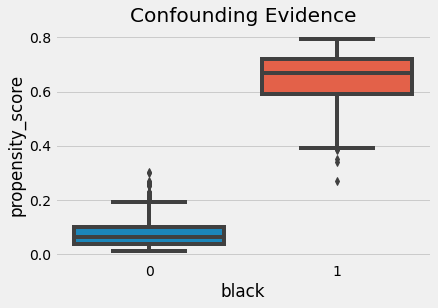

In [11]:
sns.boxplot(x="black", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence")

Text(0.5, 1.0, 'Confounding Evidence')

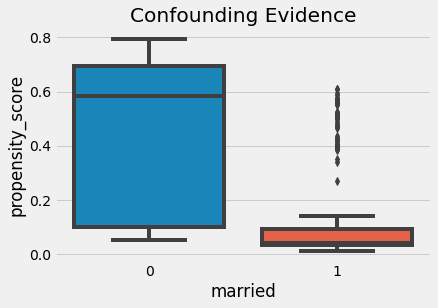

In [29]:
sns.boxplot(x="married", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence")

Text(0.5, 1.0, 'Confounding Evidence')

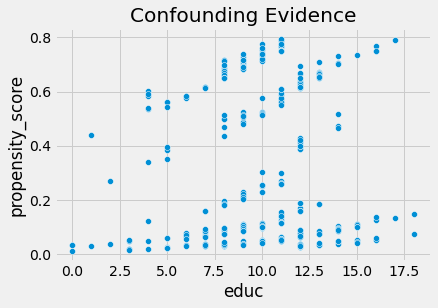

In [31]:
sns.scatterplot(x="educ", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence")

Text(0.5, 1.0, 'Confounding Evidence')

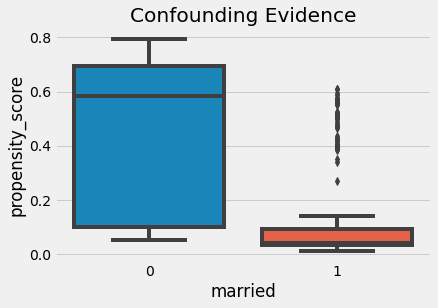

In [36]:
sns.boxplot(x="married", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence")

In [12]:
smf.ols("re78 ~ treat +age+educ+black+married+nodegree+hispan", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-814.6786,2527.166,-0.322,0.747,-5777.746,4148.388
treat,1163.9224,811.617,1.434,0.152,-430.001,2757.845
age,55.8953,32.831,1.703,0.089,-8.582,120.372
educ,525.5796,164.381,3.197,0.001,202.753,848.406
black,-1538.0720,798.864,-1.925,0.055,-3106.951,30.807
married,2136.9467,679.736,3.144,0.002,802.022,3471.871
nodegree,-36.4776,882.377,-0.041,0.967,-1769.367,1696.411
hispan,635.5281,979.152,0.649,0.517,-1287.415,2558.471


In [13]:
weight_t = 1/data_ps.query("treat==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("treat==0")["propensity_score"])
print("Original Sample Size", df.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 614
Treated Population Sample Size 581.554466115208
Untreated Population Sample Size 617.6983175808977


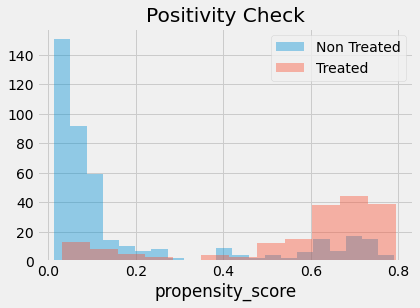

In [38]:
sns.distplot(data_ps.query("treat==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("treat==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

In [14]:
smf.ols("re78 ~ treat + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7774.0314,433.673,17.926,0.000,6922.362,8625.701
treat,1037.5022,833.071,1.245,0.213,-598.527,2673.532
propensity_score,-4294.0414,1330.883,-3.226,0.001,-6907.702,-1680.381


In [47]:
data_ps['treat2'] = data_ps['treat'].astype("bool")

In [48]:
data_ps.columns

Index(['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
       're78', 'propensity_score', 'treat2', 'ps', 'ips_weight', 'tips_weight',
       'cips_weight', 'ips_normalized_weight', 'tips_normalized_weight',
       'cips_normalized_weight', 'ips_stabilized_weight',
       'tips_stabilized_weight', 'cips_stabilized_weight', 'd_y', 'dbar_y'],
      dtype='object')

In [30]:
model=CausalModel(
        data = data_ps,
        treatment='treat2',
        outcome='re78',
        common_causes=['nodegree','black', 'hispan' ,'age','educ', 'married'])


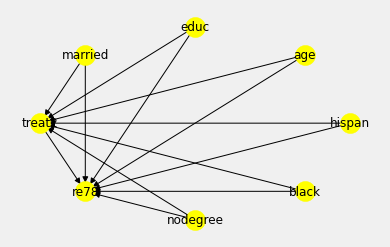

In [31]:
model.view_model()

In [32]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                              
─────────(Expectation(re78|married,educ,black,age,nodegree,hispan))
d[treat₂]                                                          
Estimand assumption 1, Unconfoundedness: If U→{treat2} and U→re78 then P(re78|treat2,married,educ,black,age,nodegree,hispan,U) = P(re78|treat2,married,educ,black,age,nodegree,hispan)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [33]:
data_ps['treat2'].unique()


array([ True, False])

In [34]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching"#,
                                              #target_units="ate"
                                              )
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                              
─────────(Expectation(re78|married,educ,black,age,nodegree,hispan))
d[treat₂]                                                          
Estimand assumption 1, Unconfoundedness: If U→{treat2} and U→re78 then P(re78|treat2,married,educ,black,age,nodegree,hispan,U) = P(re78|treat2,married,educ,black,age,nodegree,hispan)

## Realized estimand
b: re78~treat2+married+educ+black+age+nodegree+hispan
Target units: ate

## Estimate
Mean value: 443.7464178013029

Causal Estimate is 443.7464178013029


In [35]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                              
─────────(Expectation(re78|married,educ,black,age,nodegree,hispan))
d[treat₂]                                                          
Estimand assumption 1, Unconfoundedness: If U→{treat2} and U→re78 then P(re78|treat2,married,educ,black,age,nodegree,hispan,U) = P(re78|treat2,married,educ,black,age,nodegree,hispan)

## Realized estimand
b: re78~treat2+married+educ+black+age+nodegree+hispan
Target units: ate

## Estimate
Mean value: 1163.922354882914
p-value: [0.15206554]

Causal Estimate is 1163.922354882914


In [51]:
df['treat2'] = df['treat'].astype("bool")
model=CausalModel(
        data = df,
        treatment='treat2',
        outcome='re78',
        common_causes=['nodegree','black', 'hispan' ,'age','educ', 'married'])
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                              
─────────(Expectation(re78|married,educ,black,age,nodegree,hispan))
d[treat₂]                                                          
Estimand assumption 1, Unconfoundedness: If U→{treat2} and U→re78 then P(re78|treat2,married,educ,black,age,nodegree,hispan,U) = P(re78|treat2,married,educ,black,age,nodegree,hispan)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [52]:
causal_estimate_PW = model.estimate_effect(
                      identified_estimand,
                      method_name="backdoor.propensity_score_weighting"
                    )
print(causal_estimate_PW)

print("The Causal Estimate is " + str(causal_estimate_PW.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                              
─────────(Expectation(re78|married,educ,black,age,nodegree,hispan))
d[treat₂]                                                          
Estimand assumption 1, Unconfoundedness: If U→{treat2} and U→re78 then P(re78|treat2,married,educ,black,age,nodegree,hispan,U) = P(re78|treat2,married,educ,black,age,nodegree,hispan)

## Realized estimand
b: re78~treat2+married+educ+black+age+nodegree+hispan
Target units: ate

## Estimate
Mean value: -705.3458021300476

The Causal Estimate is -705.3458021300476


In [53]:
df.head()

,treat,age,educ,black,hispan,married,nodegree,re78,treat2,ps,...,tips_weight,cips_weight,ips_normalized_weight,tips_normalized_weight,cips_normalized_weight,ips_stabilized_weight,tips_stabilized_weight,cips_stabilized_weight,d_y,dbar_y
0,1,37,11,1,0,1,1,9930.0460,True,0.566415,...,0.005405,0.001784,0.003333,0.005405,0.002220,0.000866,0.001629,0.000538,28.552784,0.0
1,1,22,9,0,1,0,1,3595.8940,True,0.198996,...,0.005405,0.009383,0.009486,0.005405,0.011676,0.002466,0.001629,0.002827,29.430218,0.0
2,1,30,12,1,0,0,0,24909.4500,True,0.628286,...,0.005405,0.001379,0.003004,0.005405,0.001716,0.000781,0.001629,0.000416,64.571176,0.0
3,1,27,11,1,0,0,1,7506.1460,True,0.745733,...,0.005405,0.000795,0.002531,0.005405,0.000989,0.000658,0.001629,0.000239,16.393261,0.0
4,1,33,8,1,0,0,1,289.7899,True,0.673141,...,0.005405,0.001132,0.002804,0.005405,0.001408,0.000729,0.001629,0.000341,0.701147,0.0


OSError: cannot load library 'C:\PROGRA~1\R\R-41~1.2\bin\x64\R.dll': error 0x7e

In [7]:
df = pd.read_csv("Data/lalonde2.csv")
df.head(5)

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [8]:
df = df.astype({'treat':'bool'}, copy=False)
df.head()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,True
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,True
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,True
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,True
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,True


In [9]:
model=CausalModel(
        data = df,
        treatment='treat',
        outcome='re78',
        common_causes='nodegr+black+hisp+age+educ+married'.split('+'))
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting")
print(estimate)
#print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                          
────────(Expectation(re78|educ,nodegr,married,black,age,hisp))
d[treat]                                                      
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,educ,nodegr,married,black,age,hisp,U) = P(re78|treat,educ,nodegr,married,black,age,hisp)

## Realized estimand
b: re78~treat+educ+nodegr+married+black+age+hisp
Target units: ate

## Estimate
Mean value: 1614.1676438101076



In [10]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                          
────────(Expectation(re78|educ,nodegr,married,black,age,hisp))
d[treat]                                                      
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,educ,nodegr,married,black,age,hisp,U) = P(re78|treat,educ,nodegr,married,black,age,hisp)

## Realized estimand
b: re78~treat+educ+nodegr+married+black+age+hisp
Target units: ate

## Estimate
Mean value: 1671.1308841235068
p-value: [0.00911388]

Causal Estimate is 1671.1308841235068


In [62]:
smf.ols("re78 ~ treat +age+educ+black+married+nodegr+hisp", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1168.0115,3360.589,0.348,0.728,-5436.915,7772.938
treat[T.True],1671.1309,637.973,2.619,0.009,417.254,2925.008
age,52.8219,45.255,1.167,0.244,-36.123,141.767
educ,393.8208,227.114,1.734,0.084,-52.550,840.192
black,-2220.2623,1168.317,-1.900,0.058,-4516.481,75.957
married,158.2097,850.327,0.186,0.852,-1513.028,1829.448
nodegr,-128.2219,995.416,-0.129,0.898,-2084.620,1828.176
hisp,83.7170,1550.348,0.054,0.957,-2963.349,3130.783


In [1]:
import econml
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
#import numba

ModuleNotFoundError: No module named 'econml'

In [1]:
np.__version__

NameError: name 'np' is not defined

In [12]:
dml_estimate = model.estimate_effect(identified_estimand,
                                    method_name="backdoor.econml.dml.DML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     })
print(dml_estimate)

ImportError: Error loading econml.dml.DML. Double-check the method name and ensure that all econml dependencies are installed.

In [13]:
econml.__version__

'0.11.0'

In [14]:
df.groupby('treat')['age'].agg(['median','mean','var'])

,median,mean,var
treat,,,
0,25.0,28.030303,116.351883
1,25.0,25.816216,51.194301
